<a href="https://colab.research.google.com/github/byahram/likelion-t2-urgency-classification/blob/master/EDA/EDA_Label(text)_%EC%95%84%EB%9E%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **텍스트 EDA (w/o utterances)**

In [ ]:
!pip install -q koreanize-matplotlib

## 1. 기본 설정

In [ ]:
import os, warnings, glob, json, re, platform, shutil, re, math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import koreanize_matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

# pandas 출력 옵션 및 경고 설정
pd.set_option("display.max_columns", 120)
warnings.filterwarnings("ignore")

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 구글 드라이브
from google.colab import drive
drive.mount("/content/drive")

# 기본 경로(BASE_DIR) 설정
BASE_DIR = "/content/drive/MyDrive/Colab Data"

# !unzip -qq "/content/drive/MyDrive/Colab Data/TL_인천_기타.zip" -d "/content/drive/MyDrive/Colab Data/TL_인천"
# !unzip -qq "/content/drive/MyDrive/Colab Data/TL_인천_화재.zip" -d "/content/drive/MyDrive/Colab Data/TL_인천"
# !unzip -qq "/content/drive/MyDrive/Colab Data/TL_인천_구급.zip" -d "/content/drive/MyDrive/Colab Data/TL_인천"
# !unzip -qq "/content/drive/MyDrive/Colab Data/TL_인천_구조.zip" -d "/content/drive/MyDrive/Colab Data/TL_인천"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. 데이터 로드 및 병합

In [ ]:
# 폴더 리스트
src_dirs = [
    os.path.join(BASE_DIR, "TL_인천_구급"),
    os.path.join(BASE_DIR, "TL_인천_구조"),
    os.path.join(BASE_DIR, "TL_인천_기타"),
    os.path.join(BASE_DIR, "TL_인천_화재"),
]

all_data = []

# 폴더 리스트 순회
for src in src_dirs:
    folder_name = os.path.basename(src)
    files = sorted(glob.glob(os.path.join(src, "*.json")))

    print(f"'{folder_name}' 내 JSON 파일 수: {len(files)}개")

    for file in tqdm(files, desc=f"Loading {folder_name}"):
        try:
            with open(file, "r", encoding="utf-8") as f:
                data = json.load(f)

            # JSON 구조 평탄화
            if isinstance(data, dict):
                df_all = pd.json_normalize(data)
            elif isinstance(data, list):
                df_all = pd.json_normalize(data)
            else:
                continue

            df_all["source_folder"] = folder_name  # 폴더명 기록
            df_all["filename"] = os.path.basename(file)  # 파일명 기록
            all_data.append(df_all)

        except Exception as e:
            print(f"'{file}' 읽기 실패: {e}")

# 리스트를 하나의 DataFrame으로 합치기
df_all = pd.concat(all_data, ignore_index=True)
df_all.shape

'TL_인천_구급' 내 JSON 파일 수: 50개


Loading TL_인천_구급: 100%|██████████| 50/50 [00:00<00:00, 175.56it/s]


'TL_인천_구조' 내 JSON 파일 수: 50개


Loading TL_인천_구조: 100%|██████████| 50/50 [00:00<00:00, 168.11it/s]


'TL_인천_기타' 내 JSON 파일 수: 50개


Loading TL_인천_기타: 100%|██████████| 50/50 [00:00<00:00, 161.85it/s]


'TL_인천_화재' 내 JSON 파일 수: 50개


Loading TL_인천_화재: 100%|██████████| 50/50 [00:00<00:00, 156.47it/s]


(200, 18)

## 3. 데이터 기본 탐색 (EDA)

In [ ]:
df = df_all.copy()
df.shape

(200, 18)

In [ ]:
# 데이터 샘플
df.head()

,_id,audioPath,recordId,status,startAt,endAt,utterances,mediaType,gender,address,disasterLarge,disasterMedium,urgencyLevel,sentiment,symptom,triage,source_folder,filename
0,64d9fdff3e12da15ae3a3a00,20230814/Incheon/2023/02/11/074/converted_2023...,e71f81f3b81bdb9e4f38,12,0,46280.0,"[{'id': 'wavesurfer_4jsio8e56bo', 'startAt': 0...",Mobile,M,인천광역시,구급,질병(중증),상,중립,[],,TL_인천_구급,64d9fdff3e12da15ae3a3a00_20230211161415.json
1,64d9fdff3e12da15ae3a3a01,20230814/Incheon/2023/02/11/076/converted_2023...,183c8ad5dc045cb46064,12,0,59200.0,"[{'id': 'wavesurfer_gm0dhmvnsm', 'startAt': 0,...",Mobile,M,인천광역시,구급,부상,하,당황/난처,[],,TL_인천_구급,64d9fdff3e12da15ae3a3a01_20230211165727.json
2,64d9fdff3e12da15ae3a3a03,20230814/Incheon/2023/02/04/080/converted_2023...,1c65ebaff5c5ce601f9c,12,0,92760.0,"[{'id': '81a43f3f', 'startAt': 0, 'endAt': 160...",Mobile,F,인천광역시 계양구 계산동,구급,기타구급,중,불안/걱정,[기타],,TL_인천_구급,64d9fdff3e12da15ae3a3a03_20230204171807.json
3,64d9fdff3e12da15ae3a3a07,20230814/Incheon/2023/02/08/007/converted_2023...,06a41289f21de76a6e31,12,0,66840.0,"[{'id': '649a1e7f', 'startAt': 156, 'endAt': 1...",Mobile,M,인천광역시 남동구 만수동,구급,질병(중증 외),하,불안/걱정,"[복통, 기타, 오심, 구토]",잠재응급증상,TL_인천_구급,64d9fdff3e12da15ae3a3a07_20230208221130.json
4,64d9fdff3e12da15ae3a3a0b,20230814/Incheon/2023/02/07/016/converted_2023...,17ac6d8c57378c0aa1ca,12,0,44440.0,"[{'id': 'wavesurfer_bigmucfqtvo', 'startAt': 1...",Mobile,M,인천광역시 부평구 부평동,구급,질병(중증 외),하,불안/걱정,[기타통증],대상외,TL_인천_구급,64d9fdff3e12da15ae3a3a0b_20230207110757.json


In [ ]:
# 데이터 타입
df.dtypes

,0
_id,object
audioPath,object
recordId,object
status,int64
startAt,int64
endAt,float64
utterances,object
mediaType,object
gender,object
address,object


In [ ]:
# 데이터 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             200 non-null    object 
 1   audioPath       200 non-null    object 
 2   recordId        200 non-null    object 
 3   status          200 non-null    int64  
 4   startAt         200 non-null    int64  
 5   endAt           200 non-null    float64
 6   utterances      200 non-null    object 
 7   mediaType       200 non-null    object 
 8   gender          200 non-null    object 
 9   address         200 non-null    object 
 10  disasterLarge   200 non-null    object 
 11  disasterMedium  200 non-null    object 
 12  urgencyLevel    200 non-null    object 
 13  sentiment       200 non-null    object 
 14  symptom         200 non-null    object 
 15  triage          200 non-null    object 
 16  source_folder   200 non-null    object 
 17  filename        200 non-null    obj

In [ ]:
# 불필요한 컬럼(utterances, audioPath) 제거
drop_cols = ["audioPath", "utterances"]
df = df.drop(columns=drop_cols, errors="ignore")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             200 non-null    object 
 1   recordId        200 non-null    object 
 2   status          200 non-null    int64  
 3   startAt         200 non-null    int64  
 4   endAt           200 non-null    float64
 5   mediaType       200 non-null    object 
 6   gender          200 non-null    object 
 7   address         200 non-null    object 
 8   disasterLarge   200 non-null    object 
 9   disasterMedium  200 non-null    object 
 10  urgencyLevel    200 non-null    object 
 11  sentiment       200 non-null    object 
 12  symptom         200 non-null    object 
 13  triage          200 non-null    object 
 14  source_folder   200 non-null    object 
 15  filename        200 non-null    object 
dtypes: float64(1), int64(2), object(13)
memory usage: 25.1+ KB


In [ ]:
# 컬럼 순서 정리
col_order = [
    "_id", "recordId", "filename", "source_folder", "status",
    "startAt", "endAt", "mediaType", "gender", "address",
    "disasterLarge", "disasterMedium",
    "urgencyLevel", "sentiment", "symptom", "triage"
]

# 순서 맞추기
existing_cols = [c for c in col_order if c in df.columns]
df = df[existing_cols]

In [ ]:
# 변수 타입 변경
df["status"] = df["status"].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             200 non-null    object 
 1   recordId        200 non-null    object 
 2   filename        200 non-null    object 
 3   source_folder   200 non-null    object 
 4   status          200 non-null    object 
 5   startAt         200 non-null    int64  
 6   endAt           200 non-null    float64
 7   mediaType       200 non-null    object 
 8   gender          200 non-null    object 
 9   address         200 non-null    object 
 10  disasterLarge   200 non-null    object 
 11  disasterMedium  200 non-null    object 
 12  urgencyLevel    200 non-null    object 
 13  sentiment       200 non-null    object 
 14  symptom         200 non-null    object 
 15  triage          200 non-null    object 
dtypes: float64(1), int64(1), object(14)
memory usage: 25.1+ KB


In [ ]:
# 증상 정보가 없는 경우 `[]`: 사람이 아닌 사건 사고(화재, 구조, 교통)일 가능성 -> "해당없음"으로 변경
def clean_symptom_keep(x):
    if isinstance(x, list) and len(x) == 0:
        return "해당없음"   # 결측 아님
    return x

df["symptom"] = df["symptom"].apply(clean_symptom_keep)
df["symptom"].value_counts()

,count
symptom,
해당없음,176
[기타통증],6
[기타],2
[흉통],2
[전신쇠약],2
"[고열, 기타]",2
"[복통, 기타통증, 그밖의통증기타]",1
"[복통, 기타, 오심, 구토]",1
[가슴불편감],1


In [ ]:
# 중증도 정보 없는 경우: 환자 중증도 분류를 적용할 수 없는 신고 유형(단순 신고, 문의, 환자가 없는 신고)
df["triage"] = df["triage"].replace([None, "[]", ""], "기타")
df["triage"].value_counts()

,count
triage,
기타,177
잠재응급증상,13
응급증상,5
준응급증상,4
대상외,1


In [ ]:
# 결측치 개수 확인
df.isnull().sum().sort_values()

,0
_id,0
recordId,0
filename,0
source_folder,0
status,0
startAt,0
endAt,0
mediaType,0
gender,0
address,0


⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 결측치 처리 필요없음

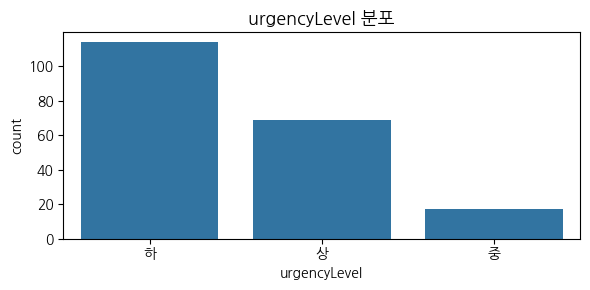

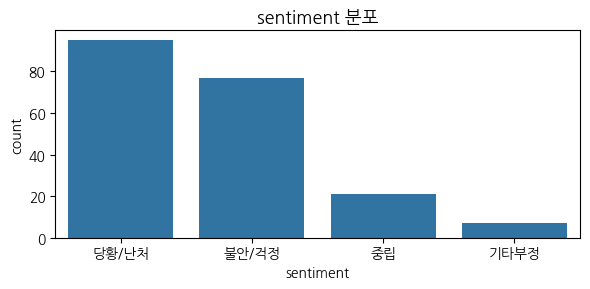

In [ ]:
# 라벨 분포 (핵심 타깃 중심)
label_cols = ["urgencyLevel", "sentiment"]

for c in label_cols:
    if c in df.columns:
        vc = df[c].value_counts(dropna=False)
        plt.figure(figsize=(6,3))
        sns.barplot(x=vc.index, y=vc.values)
        plt.title(f"{c} 분포", fontsize=13)
        plt.xlabel(c)
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- **urgencyLevel**
    - `하`가 전체의 약 절반 이상을 차지 -> 대부분의 신고가 즉각적인 생명 위협 상황은 아님.
    - `중`, `상`은 상대적으로 적어 클래스 불균형(class imbalance) 존재.
        - 모델 학습 시 class weighting 또는 SMOTE/Oversampling 등 보완 필요(?)
- **sentiment**
    - 주요 감정은 `당황/난처`와 `불안/걱정`이 대부분을 차지.
        - 실제 119 신고의 감정 패턴은 “긴급도 낮지만 정서적 긴장도가 높은 상황
    - `중립`과 `기타부정`은 상대적으로 적어, 감정 데이터 역시 불균형.


In [ ]:
# 중복/유니크 키 확인
# recordId, filename, _id 중복 확인
for key in [ "_id", "recordId", "filename"]:
    if key in df.columns:
        dup = df[key].duplicated().sum()
        nunique = df[key].nunique()
        print(f"\n{key}: 중복 {dup}건 / 유니크 {nunique}개")


_id: 중복 0건 / 유니크 200개

recordId: 중복 0건 / 유니크 200개

filename: 중복 0건 / 유니크 200개


## 4. 수치형 변수(`startAt`/`endAt`)

In [ ]:
# 수치형 기본 통계
df.describe()

,startAt,endAt
count,200.0,200.000000
mean,0.0,67860.800000
std,0.0,30110.037382
min,0.0,30080.000000
25%,0.0,45470.000000
50%,0.0,59460.000000
75%,0.0,83620.000000
max,0.0,167120.000000


In [ ]:
# duration 계산
df["duration_ms"] = pd.to_numeric(df["endAt"], errors="coerce") - pd.to_numeric(df["startAt"], errors="coerce")
df["duration_sec"] = df["duration_ms"] / 1000

In [ ]:
# 이상치 확인
# df["duration_ms"] = 음수 확인
print(((df["duration_ms"]) < 0).sum())

# df["duration_ms"] = 0 확인
print(((df["duration_ms"]) == 0).sum())

0
0


In [ ]:
df.describe()

,startAt,endAt,duration_ms,duration_sec
count,200.0,200.000000,200.000000,200.000000
mean,0.0,67860.800000,67860.800000,67.860800
std,0.0,30110.037382,30110.037382,30.110037
min,0.0,30080.000000,30080.000000,30.080000
25%,0.0,45470.000000,45470.000000,45.470000
50%,0.0,59460.000000,59460.000000,59.460000
75%,0.0,83620.000000,83620.000000,83.620000
max,0.0,167120.000000,167120.000000,167.120000


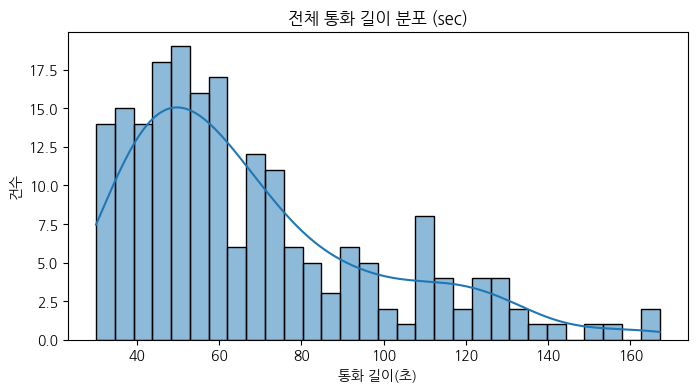

In [ ]:
# 전체 duration 분포
plt.figure(figsize=(8,4))
sns.histplot(df["duration_sec"], bins=30, kde=True)
plt.title("전체 통화 길이 분포 (sec)")
plt.xlabel("통화 길이(초)")
plt.ylabel("건수")
plt.show()

In [ ]:
df["duration_sec"].describe().to_frame()

,duration_sec
count,200.000000
mean,67.860800
std,30.110037
min,30.080000
25%,45.470000
50%,59.460000
75%,83.620000
max,167.120000


⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 평균 통화 시간 : 약 68초
    - 신고 응답 및 조치까지 평균 1분 내외 소요
- 통화 시간 이상치(음수/0) 없음
- duration_sec은 유용한 feature라고 생각
- 짧은 통화 중심, 긴 꼬리(long tail)

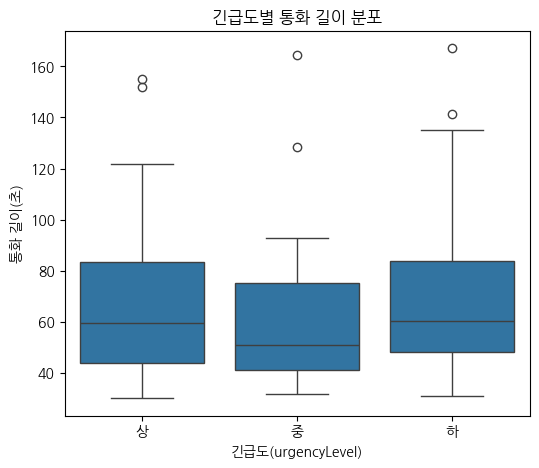

In [ ]:
# 긴급도별 통화 길이 비교
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="urgencyLevel", y="duration_sec", order=["상","중","하"])
plt.title("긴급도별 통화 길이 분포")
plt.xlabel("긴급도(urgencyLevel)")
plt.ylabel("통화 길이(초)")
plt.show()

In [ ]:
# 긴급도별 평균 통화길이(초)
if {"urgencyLevel", "duration_sec"}.issubset(df.columns):
    mean_by_urgency = df.groupby("urgencyLevel")["duration_sec"].mean().sort_values(ascending=False)
    display(mean_by_urgency.to_frame())

,duration_sec
urgencyLevel,
하,68.590526
상,67.582029
중,64.098824


⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 세 그룹 모두 중앙값이 약 60~70초
- `상`과 `하` 수준이 유사한 분포를 가지고 있음 : 유의미한 차이 작을 가능성
- 긴급도가 높다고 통화가 길어지지 않는다.
- `duration_sec`만으로는 긴급도를 직접적으로 예측하기엔 한계가 있지 않을까?

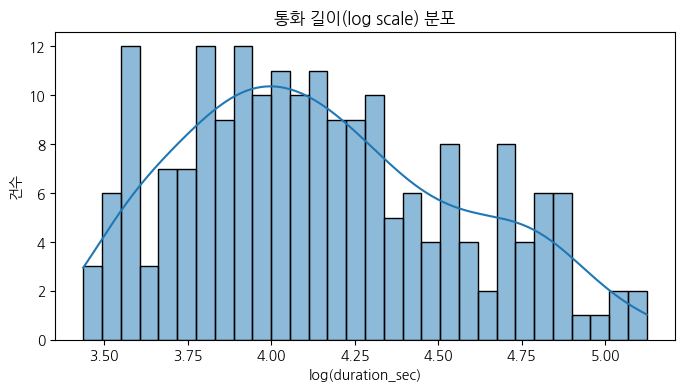

In [ ]:
## 통화 길이 log scale 분포 확인 (0 방지용 log(1+x)
df["log_duration"] = np.log1p(df["duration_sec"])

plt.figure(figsize=(8,4))
sns.histplot(df["log_duration"], bins=30, kde=True)
plt.title("통화 길이(log scale) 분포")
plt.xlabel("log(duration_sec)")
plt.ylabel("건수")
plt.show()

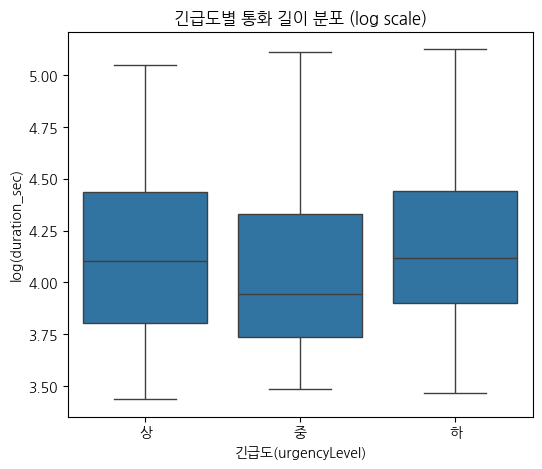

In [ ]:
# 긴급도별 log-duration 박스플롯
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="urgencyLevel", y="log_duration", order=["상","중","하"])
plt.title("긴급도별 통화 길이 분포 (log scale)")
plt.xlabel("긴급도(urgencyLevel)")
plt.ylabel("log(duration_sec)")
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 극단치(긴 통화)의 영향을 줄여 "실제 분포 형태"를 확인
- 로그 변환으로 통화 길이 분포는 안정화되었지만 긴급도에 따른 통화 길이 차이는 여전히 미미함.
- `duration_sec`는 보조 피처로 유지

## 5. 범주형 변수

In [ ]:
df.columns

Index(['_id', 'recordId', 'filename', 'source_folder', 'status', 'startAt',
       'endAt', 'mediaType', 'gender', 'address', 'disasterLarge',
       'disasterMedium', 'urgencyLevel', 'sentiment', 'symptom', 'triage',
       'duration_ms', 'duration_sec', 'log_duration'],
      dtype='object')

In [ ]:
## EDA 대상 범주형 컬럼
cat_cols = ["mediaType", "gender", "address", "disasterLarge", "disasterMedium", "urgencyLevel", "sentiment", "symptom", "triage"]
cat_cols = [c for c in cat_cols if c in df.columns]

In [ ]:
# 결측치 비율 확인
(df[cat_cols].isna().mean() * 100).round(1).to_frame("결측률(%)")

,결측률(%)
mediaType,0.0
gender,0.0
address,0.0
disasterLarge,0.0
disasterMedium,0.0
urgencyLevel,0.0
sentiment,0.0
symptom,0.0
triage,0.0


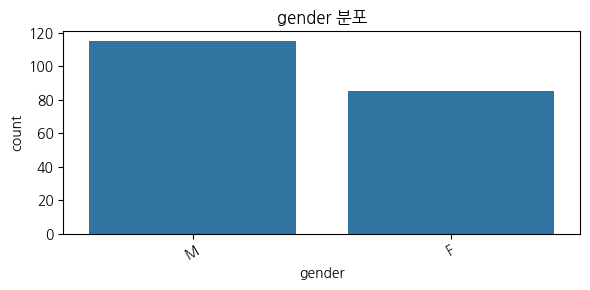

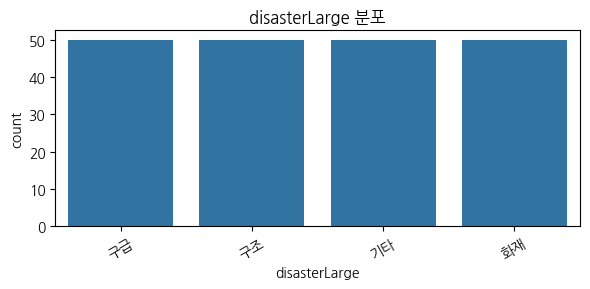

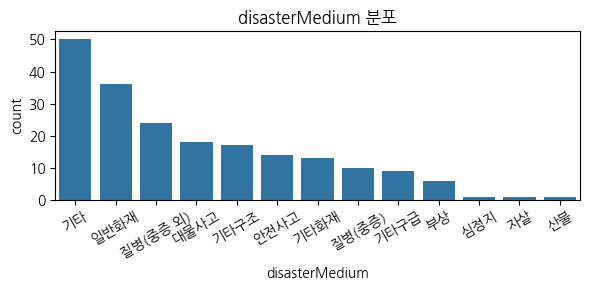

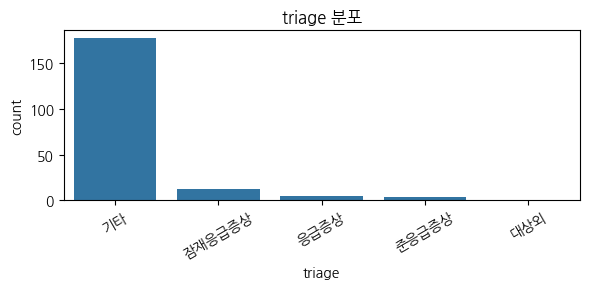

In [ ]:
# 범주형 변수 전체 탐색용
cat_cols = ["gender", "disasterLarge", "disasterMedium", "triage"]

for c in cat_cols:
    if c in df.columns:
        plt.figure(figsize=(6,3))
        sns.countplot(x=c, data=df, order=df[c].value_counts().index)
        plt.title(f"{c} 분포")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- gender: 남성 비율 높음(환경적 요인?), 보조적 변수로 유용
- disasterLarge: 의도적으로 50개씩 분석이라 pass
- disasterMedium, triage: 클래스 불균형

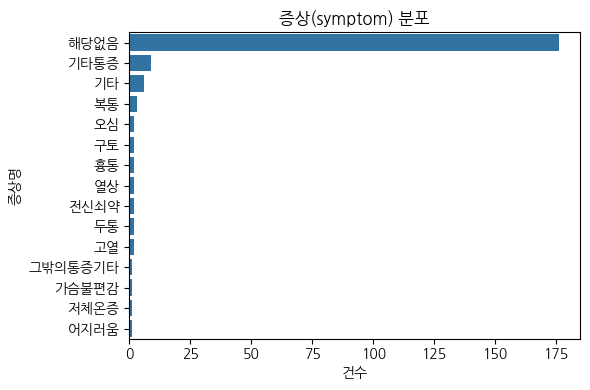

In [ ]:
## symptom 컬럼 (list -> 개별)
df_sym = df.explode("symptom").copy()
df_sym["symptom"] = df_sym["symptom"].fillna("미기재")

plt.figure(figsize=(6,4))
sns.countplot(y="symptom", data=df_sym, order=df_sym["symptom"].value_counts().index)
plt.title("증상(symptom) 분포")
plt.xlabel("건수")
plt.ylabel("증상명")
plt.tight_layout()
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 증상 미기재가 압도적


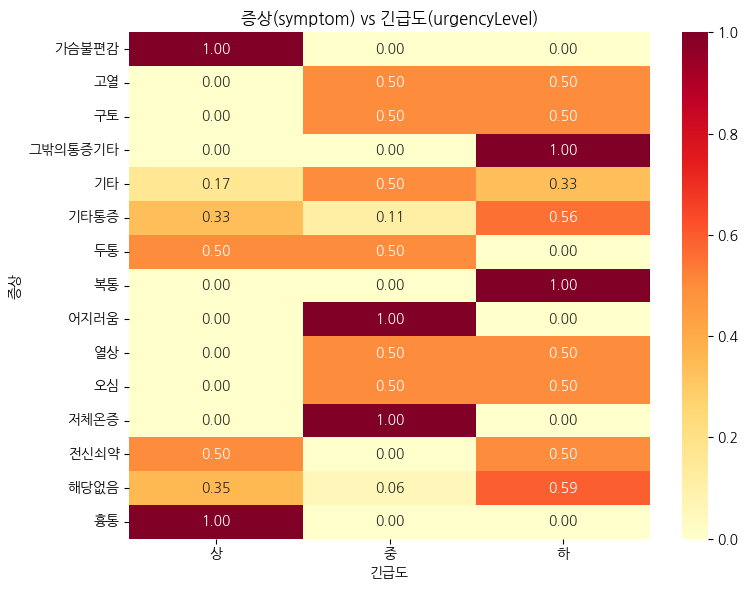

In [ ]:
# 긴급도별 증상 교차표 (비율)
ct_sym = pd.crosstab(df_sym["symptom"], df_sym["urgencyLevel"], normalize="index").round(3)
plt.figure(figsize=(8,6))
sns.heatmap(ct_sym, cmap="YlOrRd", annot=True, fmt=".2f")
plt.title("증상(symptom) vs 긴급도(urgencyLevel)")
plt.xlabel("긴급도")
plt.ylabel("증상")
plt.tight_layout()
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 증상별 긴급도 분포 불균등
- 일부 증상은 `하`(기타통증, 미기재, 복통, 어지러움, 저체온증)로 치우치고, 일부는 `상`(가슴불편감, 흉통)으로 치우침
- 증상 종류에 따라 긴급도 인식 뚜렷하게 다름
- 증상 유형별 가중치(feature importance) 강력

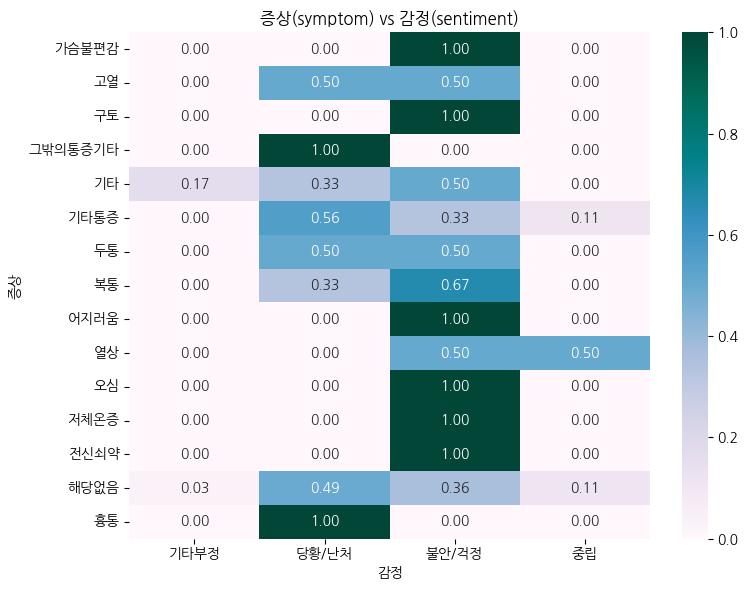

In [ ]:
 # 감정별 증상 교차표 (비율)
ct_sent_sym = pd.crosstab(df_sym["symptom"], df_sym["sentiment"], normalize="index").round(3)
plt.figure(figsize=(8,6))
sns.heatmap(ct_sent_sym, cmap="PuBuGn", annot=True, fmt=".2f")
plt.title("증상(symptom) vs 감정(sentiment)")
plt.xlabel("감정")
plt.ylabel("증상")
plt.tight_layout()
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- `당황/난처` 또는 `불안/걱정` 연관
- `증상`과 `감정`은 명확한 상관 패턴: 감정적 긴장도가 높을수록 증상 뚜렷
- `symptom` x `sentiment` 조합 feature??

## 6. 주소 기반 분석

In [ ]:
df["address"].unique()

array(['인천광역시', '인천광역시 계양구 계산동', '인천광역시 남동구 만수동', '인천광역시 부평구 부평동',
       '인천광역시 남동구 논현동', '인천광역시 중구 운서동', '인천광역시 부평구 갈산동', '인천광역시 미추홀구 도화동',
       '인천광역시 미추홀구 문학동', '인천광역시 서구 청라동', '인천광역시 동구 송림동', '인천광역시 미추홀구 주안동',
       '인천광역시 부평구 부개동', '인천광역시 남동구 구월동', '인천광역시 중구 운남동', '인천광역시 남동구 서창동',
       '인천광역시 중구 송월동2가', '인천광역시 연수구 송도동', '인천광역시 서구 검암동', '인천광역시 동구 송현동',
       '인천광역시 계양구 작전동', '인천광역시 연수구 동춘동', '인천광역시 남동구 장수동', '인천광역시 서구 원당동',
       '인천광역시 강화군 강화읍', '인천광역시 서구 가정동', '인천광역시 옹진군 북도면', '인천광역시 서구 왕길동',
       '인천광역시 강화군 길상면', '인천광역시 부평구 십정동', '인천광역시 서구 석남동', '인천광역시 강화군 하점면',
       '인천광역시 미추홀구 용현동'], dtype=object)

In [ ]:
df["address"].nunique()

33

In [ ]:
df["address"].value_counts()

,count
address,
인천광역시,138
인천광역시 부평구 부평동,9
인천광역시 남동구 만수동,4
인천광역시 중구 운서동,4
인천광역시 미추홀구 주안동,4
인천광역시 남동구 구월동,3
인천광역시 남동구 서창동,3
인천광역시 동구 송림동,3
인천광역시 계양구 계산동,2


In [ ]:
def parse_address(addr):
    if not isinstance(addr, str) or not addr.strip():
        return ('-', '-', '-')

    parts = addr.strip().split()
    addr1, addr2, addr3 = '-', '-', '-'

    # 1. 시
    if len(parts) >= 1:
        addr1 = parts[0]

    # 2. 구 or 군
    if len(parts) >= 2:
        addr2 = parts[1]

    # 3. 동 or 면 or 읍 등
    if len(parts) >= 3:
        addr3 = parts[2]
    else:
        # 없는 경우 — 시 단위만 존재
        addr3 = '-'

    return (addr1, addr2, addr3)

df[['addr1', 'addr2', 'addr3']] = df['address'].apply(
    lambda x: pd.Series(parse_address(x))
)

df[['address', 'addr1', 'addr2', 'addr3']].head(10)


,address,addr1,addr2,addr3
0,인천광역시,인천광역시,-,-
1,인천광역시,인천광역시,-,-
2,인천광역시 계양구 계산동,인천광역시,계양구,계산동
3,인천광역시 남동구 만수동,인천광역시,남동구,만수동
4,인천광역시 부평구 부평동,인천광역시,부평구,부평동
5,인천광역시,인천광역시,-,-
6,인천광역시 남동구 논현동,인천광역시,남동구,논현동
7,인천광역시 중구 운서동,인천광역시,중구,운서동
8,인천광역시,인천광역시,-,-
9,인천광역시,인천광역시,-,-


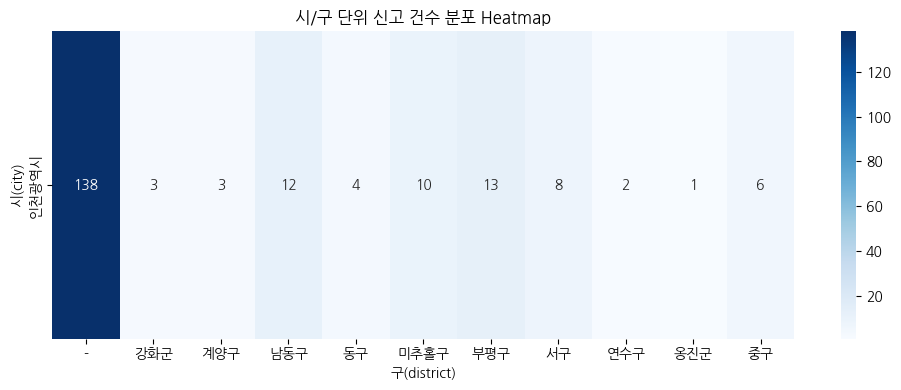

In [ ]:
# 시/구 단위 신고 건수 분포
pivot_city_district = (
    df.groupby(["addr1", "addr2"])
    .size()
    .reset_index(name="count")
    .pivot(index="addr1", columns="addr2", values="count")
    .fillna(0)
)

plt.figure(figsize=(10,4))
sns.heatmap(pivot_city_district, annot=True, fmt=".0f", cmap="Blues")
plt.title("시/구 단위 신고 건수 분포 Heatmap")
plt.xlabel("구(district)");
plt.ylabel("시(city)")
plt.tight_layout()
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 지역별 데이터 수 차이가 커서 모델 학습 시 지역 편향 가능성 존재.
- 시 단위로만 단순화(addr1)유지하기
- 지역 불균형 보정(scaling or filtering) 필요

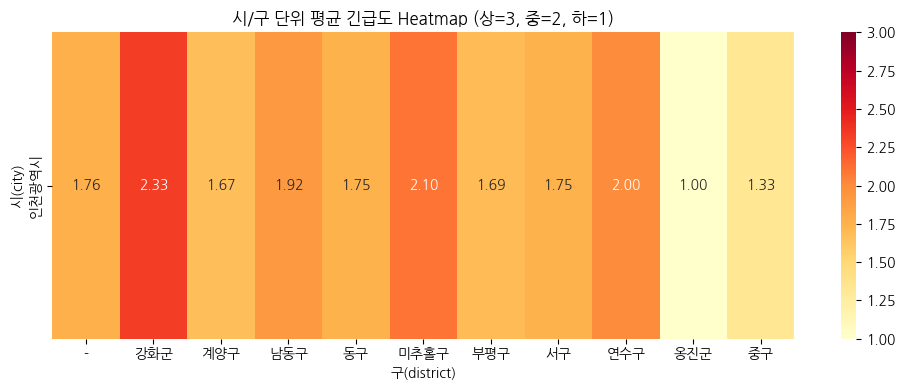

In [ ]:
# 긴급도를 수치로 변환: 상=3, 중=2, 하=1
level_map = {"상":3, "중":2, "하":1}
df["urgencyNum"] = df["urgencyLevel"].map(level_map)

# 시/구 단위 평균 긴급도
urgency_by_district = (
    df.groupby(["addr1", "addr2"])["urgencyNum"]
    .mean()
    .reset_index()
    .pivot(index="addr1", columns="addr2", values="urgencyNum")
)

plt.figure(figsize=(10,4))
sns.heatmap(urgency_by_district, annot=True, fmt=".2f", cmap="YlOrRd", vmin=1, vmax=3)
plt.title("시/구 단위 평균 긴급도 Heatmap (상=3, 중=2, 하=1)")
plt.xlabel("구(district)");
plt.ylabel("시(city)")
plt.tight_layout()
plt.show()

In [ ]:
# 시/구 단위 평균 긴급도 상위 TOP 10]
top10 = (
    df.groupby(["addr1", "addr2"])["urgencyNum"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
display(top10.to_frame())

urgencyNum
addr1 addr2            
인천광역시 강화군      2.333333
      미추홀구     2.100000
      연수구      2.000000
      남동구      1.916667
      -        1.760870
      서구       1.750000
      동구       1.750000
      부평구      1.692308
      계양구      1.666667
      중구       1.333333

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 강화/미추홀/연수구는 평균 긴급도가 높아 응급 출동 중심 지역으로 분류, 웅진군/중구는 낮은 긴급도로 일반 신고 중심 지역
- 긴급도 예측 모델의 지리적 가중치 설정 정도

## 7. 교차분석(시각화 중심)

- 긴급도 vs 감정

In [ ]:
# 교차표(빈도)
ct = pd.crosstab(df["urgencyLevel"], df["sentiment"])
ct

sentiment,기타부정,당황/난처,불안/걱정,중립
urgencyLevel,,,,
상,2,44,17,6
중,1,4,11,1
하,4,47,49,14


In [ ]:
# 교차표(행 정규화 비율)
ct_norm = pd.crosstab(df["urgencyLevel"], df["sentiment"], normalize="index").round(3)
ct_norm

sentiment,기타부정,당황/난처,불안/걱정,중립
urgencyLevel,,,,
상,0.029,0.638,0.246,0.087
중,0.059,0.235,0.647,0.059
하,0.035,0.412,0.430,0.123


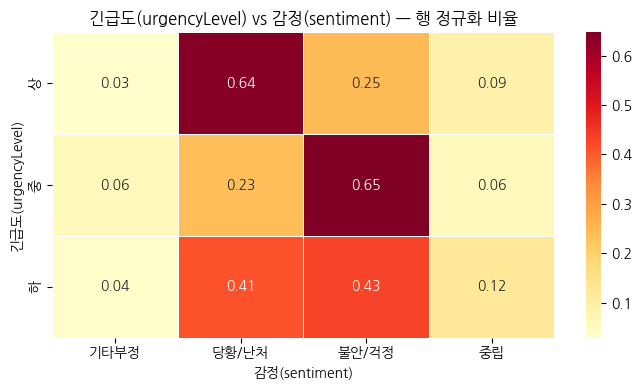

In [ ]:
# 히트맵 시각화
plt.figure(figsize=(7,4))
sns.heatmap(ct_norm, annot=True, cmap="YlOrRd", fmt=".2f", linewidths=.5)
plt.title("긴급도(urgencyLevel) vs 감정(sentiment) — 행 정규화 비율")
plt.xlabel("감정(sentiment)")
plt.ylabel("긴급도(urgencyLevel)")
plt.tight_layout()
plt.show()

In [ ]:
# 카이제곱 & Cramér’s V 계산
chi2, p, dof, exp = chi2_contingency(ct)
n = ct.to_numpy().sum()
cramer_v = np.sqrt(chi2 / (n * (min(ct.shape)-1))) if min(ct.shape) > 1 else np.nan

print(f"카이제곱 통계량 = {chi2:.3f}")
print(f"p-value = {p:.4g}")
print(f"Cramer's V = {cramer_v:.3f}")


카이제곱 통계량 = 15.167
p-value = 0.019
Cramer's V = 0.195


⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 긴급도 `상`에서 `당황/난처`가 비중이 높음
- 카이제곱(15.167) : `긴급도`와 `감정`은 완전 독립 아님
- p-value(0.019(<0.05)) : 통계적으로 유의미한 연관성 존재
- Cramer's V(0.195): 약한 상관관계

- 긴급도(urgencyLevel) vs 주요 변수

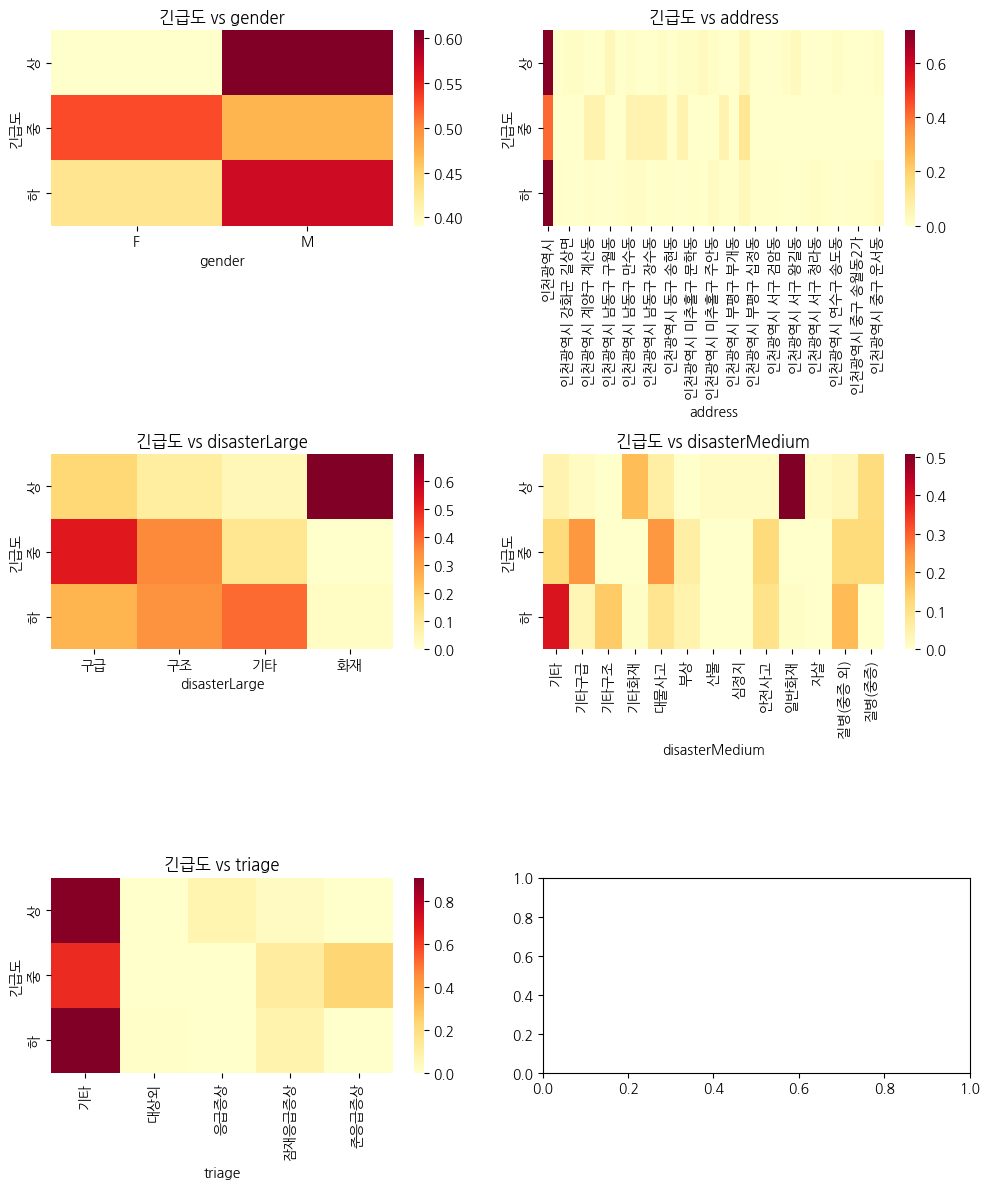

In [ ]:
## 긴급도(urgencyLevel) vs 주요 변수
rel_cols = ["gender", "address", "disasterLarge", "disasterMedium", "triage"]
rel_cols = [c for c in rel_cols if c in df.columns]

n_cols = 2
n_rows = math.ceil(len(rel_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(rel_cols):
    ct = pd.crosstab(df["urgencyLevel"], df[col], normalize="index").round(3)
    sns.heatmap(ct, cmap="YlOrRd", ax=axes[i])
    axes[i].set_title(f"긴급도 vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("긴급도")

plt.tight_layout()
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- genter: 남성(M) 신고자의 긴급도가 상대적으로 높게 나타남
- address: 지역별 긴급도 편차는 있으나 극단적이지 않음
- disasterLarge, disasterMedium: 화재 사고가 가장 즉각적인 긴급 대응 필요로 분류


- 감정(sentiment) vs 주요 변수

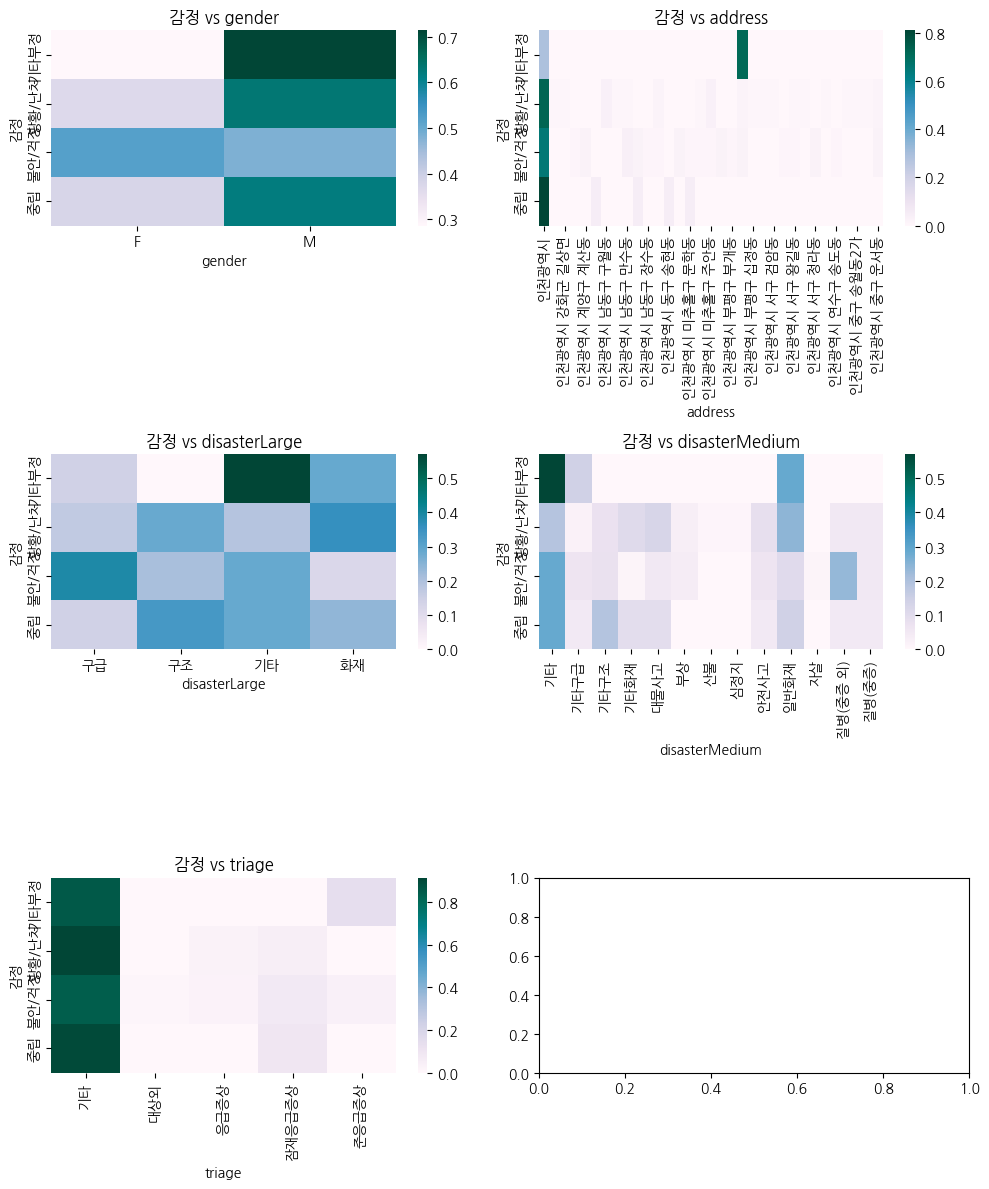

In [ ]:
## 감정(sentiment) vs 주요 변수
rel_cols_sent = ["gender", "address", "disasterLarge", "disasterMedium", "triage"]
rel_cols_sent = [c for c in rel_cols_sent if c in df.columns]

n_cols = 2
n_rows = math.ceil(len(rel_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(rel_cols_sent):
    ct = pd.crosstab(df["sentiment"], df[col], normalize="index").round(3)
    sns.heatmap(ct, cmap="PuBuGn", ax=axes[i])
    axes[i].set_title(f"감정 vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("감정")

plt.tight_layout()
plt.show()

- mediaType 영향 분석

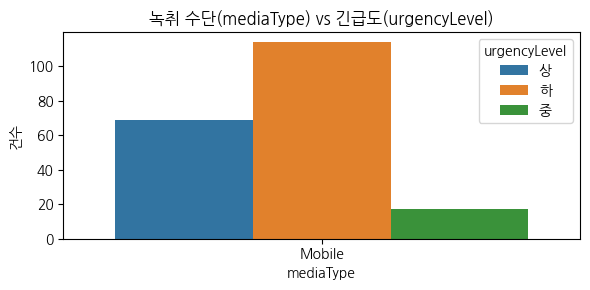

In [ ]:
# mediaType 영향 분석
plt.figure(figsize=(6,3))
sns.countplot(x="mediaType", hue="urgencyLevel", data=df, order=df["mediaType"].value_counts().index)
plt.title("녹취 수단(mediaType) vs 긴급도(urgencyLevel)")
plt.xlabel("mediaType")
plt.ylabel("건수")
plt.tight_layout()
plt.show()

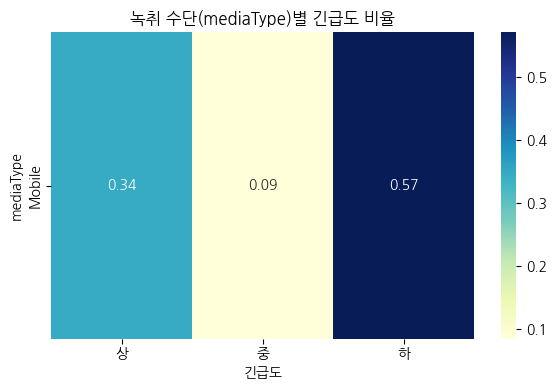

In [ ]:
 # 교차표 (비율)
ct_media = pd.crosstab(df["mediaType"], df["urgencyLevel"], normalize="index").round(3)
plt.figure(figsize=(6,4))
sns.heatmap(ct_media, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("녹취 수단(mediaType)별 긴급도 비율")
plt.xlabel("긴급도")
plt.ylabel("mediaType")
plt.tight_layout()
plt.show()

## 8. 상관도

In [ ]:
df.columns

Index(['_id', 'recordId', 'filename', 'source_folder', 'status', 'startAt',
       'endAt', 'mediaType', 'gender', 'address', 'disasterLarge',
       'disasterMedium', 'urgencyLevel', 'sentiment', 'symptom', 'triage',
       'duration_ms', 'duration_sec', 'log_duration', 'addr1', 'addr2',
       'addr3', 'urgencyNum'],
      dtype='object')

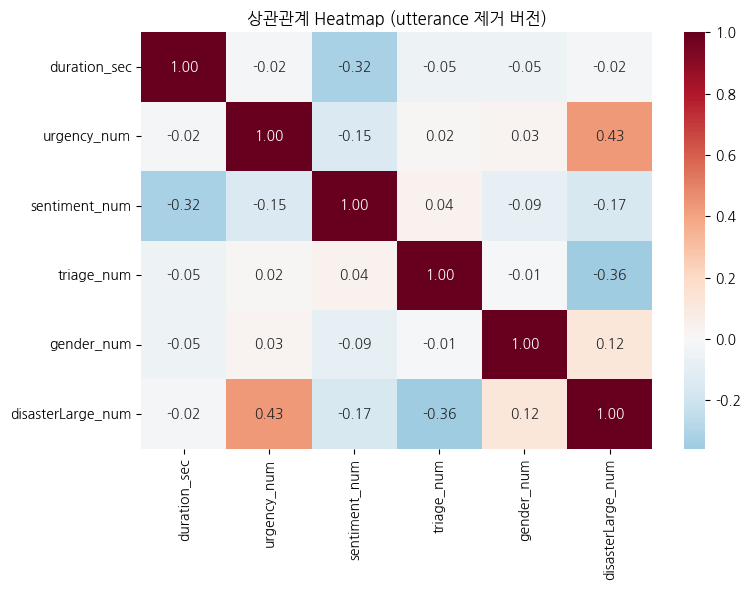

In [ ]:
# 긴급도 숫자화
df["urgency_num"] = df["urgencyLevel"].map({"상":3, "중":2, "하":1})

# 범주형 -> 수치형 변환
cat_cols = ["sentiment", "triage", "gender", "disasterLarge"]
for c in cat_cols:
    if c in df.columns:
        le = LabelEncoder()
        df[c + "_num"] = le.fit_transform(df[c].astype(str))

# 상관계수 계산
num_cols = ["duration_sec", "urgency_num"] + [c + "_num" for c in cat_cols if c + "_num" in df.columns]
corr = df[num_cols].corr(method="pearson")

plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="RdBu_r", annot=True, fmt=".2f", center=0)
plt.title("상관관계 Heatmap (utterance 제거 버전)")
plt.tight_layout()
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- `긴급도`와 `disasterLarge`가 가장 높은 상관을 가지지만 +0.43으로 “이 변수 하나로 긴급도를 설명한다”고 하기엔 설명력이 약한 수준
- 그래서 텍스트 기반(글자수, 토큰수)와 함께 분석하려 함

# **텍스트 EDA (w/ utterances)**

## 1. (utterances 기반) EDA

In [ ]:
df = df_all.copy()
print("현재 컬럼 목록:", list(df.columns))

현재 컬럼 목록: ['_id', 'audioPath', 'recordId', 'status', 'startAt', 'endAt', 'utterances', 'mediaType', 'gender', 'address', 'disasterLarge', 'disasterMedium', 'urgencyLevel', 'sentiment', 'symptom', 'triage', 'source_folder', 'filename']


In [ ]:
df["utterances"][0]

[{'id': 'wavesurfer_4jsio8e56bo',
  'startAt': 0,
  'endAt': 1892,
  'text': '네 인천공항 고속도로 교통 센터인데요.',
  'speaker': 1},
 {'id': 'wavesurfer_5omf7nro3l',
  'startAt': 2475,
  'endAt': 4767,
  'text': '저희 하부도로',
  'speaker': 1},
 {'id': 'wavesurfer_dh4b9j9qrig',
  'startAt': 5234,
  'endAt': 6976,
  'text': '14.1k 서울 방향',
  'speaker': 1},
 {'id': 'wavesurfer_0k8pt3nbu5g',
  'startAt': 6917,
  'endAt': 8051,
  'text': '서울 방향 하부',
  'speaker': 0},
 {'id': 'wavesurfer_8p4s0nh1nlg',
  'startAt': 8198,
  'endAt': 10773,
  'text': '14.1k 지금 2중 추돌 있는데.',
  'speaker': 1},
 {'id': 'wavesurfer_bogjkenihag',
  'startAt': 11723,
  'endAt': 12131,
  'text': '네',
  'speaker': 0},
 {'id': 'wavesurfer_hu5tmbu6bb8',
  'startAt': 12348,
  'endAt': 17102,
  'text': '그 이렇게 한 분이 이렇게 가슴 쪽을 붙잡고 계셔 가지고 혹시 몰라서.',
  'speaker': 1},
 {'id': 'wavesurfer_vtue4ndcqto',
  'startAt': 16752,
  'endAt': 17677,
  'text': '카메라로 보시는 거예요?',
  'speaker': 0},
 {'id': 'wavesurfer_cfv9c9gj5og',
  'startAt': 17816,
  'endAt': 18416

In [ ]:
# Helper 함수
def safe_len(x):
    try: return len(x) if isinstance(x, list) else 0
    except: return 0

# 텍스트 병합
def concat_texts(utt_list):
    if isinstance(utt_list, list):
        texts = [u.get("text", "") for u in utt_list if isinstance(u, dict)]
        return " ".join(texts).strip()
    return ""

# 화자별 분리: 0=수보자(상담원), 1=신고자
def concat_by_role(utt_list, role_id):
    if not isinstance(utt_list, list):
        return ""
    return " ".join([u.get("text", "") for u in utt_list if isinstance(u, dict) and u.get("speaker") == role_id]).strip()

In [ ]:
# 기본 피처: 역할별 concat 텍스트
df["text_receiver"] = df["utterances"].apply(lambda x: concat_by_role(x, 0))  # 수보자
df["text_caller"]   = df["utterances"].apply(lambda x: concat_by_role(x, 1))  # 신고자

# 문자수
df["receiver_char_len"] = df["text_receiver"].str.len()
df["caller_char_len"]   = df["text_caller"].str.len()

# 단어수(공백 기준 토큰)
df["receiver_tok_len"] = df["text_receiver"].apply(lambda s: len(s.split()))
df["caller_tok_len"]   = df["text_caller"].apply(lambda s: len(s.split()))

# 비율(신고자/수보자) — 0 나눗셈 방지
df["caller_receiver_ratio_char"] = df["caller_char_len"] / (df["receiver_char_len"] + 1)
df["caller_receiver_ratio_tok"]  = df["caller_tok_len"]  / (df["receiver_tok_len"]  + 1)

# 통화 총 길이(초)
df["total_duration_ms"] = pd.to_numeric(df["endAt"], errors="coerce") - pd.to_numeric(df["startAt"], errors="coerce")
df["total_duration_s"]  = (df["total_duration_ms"] / 1000).round(1)

df[["filename", "text_receiver", "text_caller", "receiver_char_len", "caller_char_len",
            "receiver_tok_len", "caller_tok_len", "caller_receiver_ratio_char", "caller_receiver_ratio_tok", "total_duration_s"]].head()


,filename,text_receiver,text_caller,receiver_char_len,caller_char_len,receiver_tok_len,caller_tok_len,caller_receiver_ratio_char,caller_receiver_ratio_tok,total_duration_s
0,64d9fdff3e12da15ae3a3a00_20230211161415.json,"서울 방향 하부 네 카메라로 보시는 거예요? 영종대교 합파로 가면 돼요? 누가, 누...",네 인천공항 고속도로 교통 센터인데요. 저희 하부도로 14.1k 서울 방향 14.1...,141,168,40,47,1.183099,1.146341,46.3
1,64d9fdff3e12da15ae3a3a01_20230211165727.json,119입니다. 강화 어디 근처요? 군 강화 군청 근처요? 아 혹시 그 구급차는 필요...,예. 여기 지금 강화 군청 근처인데요. 어 군청 근처요. 네. 근데 애기가 놀다가 ...,150,193,38,56,1.278146,1.435897,59.2
2,64d9fdff3e12da15ae3a3a03_20230204171807.json,"다. 네. 예, [개인정보] 선생님 위, 위층이요? 네, 네, 네. 예, 예. 아,...","네, 안녕하세요, 저 여기 인천 계양구 계양대로 [개인정보] 저희 그 [개인정보] ...",216,236,53,60,1.087558,1.111111,92.8
3,64d9fdff3e12da15ae3a3a07_20230208221130.json,"네, 119입니다. 식은땀 나고 아, 힘들다. 그래서 구급차 필요하신 거죠? 예....","예, 제가 식은땀 나고 메스꺼워 가 메스꺼운 기가 있어 가지고 토를 했어. 그래 가...",162,102,37,24,0.625767,0.631579,66.8
4,64d9fdff3e12da15ae3a3a0b_20230207110757.json,"119입니다. 아 예예 위치 알려주세요. 몇 동 몇 호예요? 한 동 짜리예요? 아,...","아 네, 저희 아버지가. 그 지금 거동이 많이 힘드신데, 그 다리가 지금 많이 부어...",153,159,41,41,1.032468,0.976190,44.4


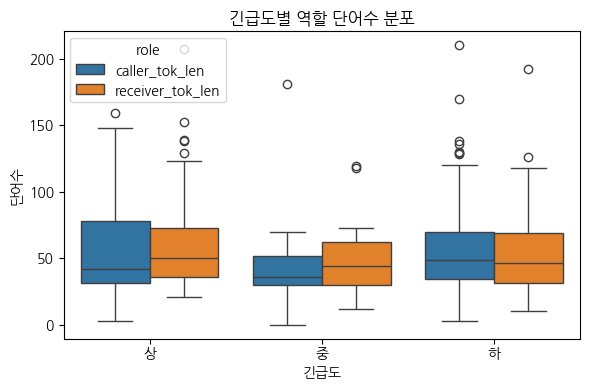

In [ ]:
order_levels = ["상","중","하"] if "urgencyLevel" in df.columns else None

# 긴급도별 신고자/수보자 단어수
plt.figure(figsize=(6,4))
sns.boxplot(data=df.melt(id_vars=["urgencyLevel"],
                            value_vars=["caller_tok_len","receiver_tok_len"],
                            var_name="role", value_name="tok_len"),
            x="urgencyLevel", y="tok_len", hue="role",
            order=order_levels)
plt.title("긴급도별 역할 단어수 분포")
plt.xlabel("긴급도"); plt.ylabel("단어수")
plt.tight_layout(); plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 긴급도와 신고자 발화량은 유의미하게 연결됨
    - 긴급도가 높을수록 신고자가 말을 더 많이 하고, 수보자는 비교적 일정한 응답량을 유지
- `발화 비율`, `단어 수`는 feature로 활용 가치가 있다고 생각함

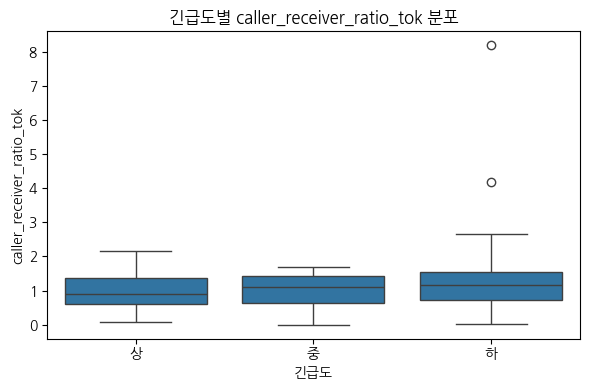

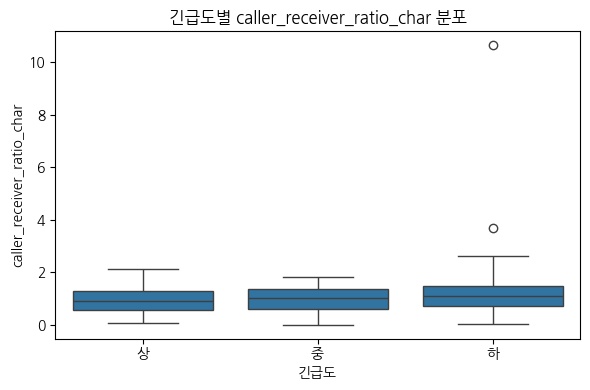

In [ ]:
# 긴급도별 비율(신고자/수보자)
for col in ["caller_receiver_ratio_tok", "caller_receiver_ratio_char"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="urgencyLevel", y=col, order=order_levels)
    plt.title(f"긴급도별 {col} 분포")
    plt.xlabel("긴급도");
    plt.ylabel(col)
    plt.tight_layout();
    plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆

- 전반적으로 긴급도별 신고자/수보자 비율은 유사하지만, 긴급도 `상` 구간에서 신고자 중심 발화가 높게 나타남
- 그러나 차이가 작아서 유의미한 신호로 보기에는 어려움
- 이상치 구간에서 오히려 극단적 긴급 신고 or 불필요 신고 구분 활용가능 하지 않을까?

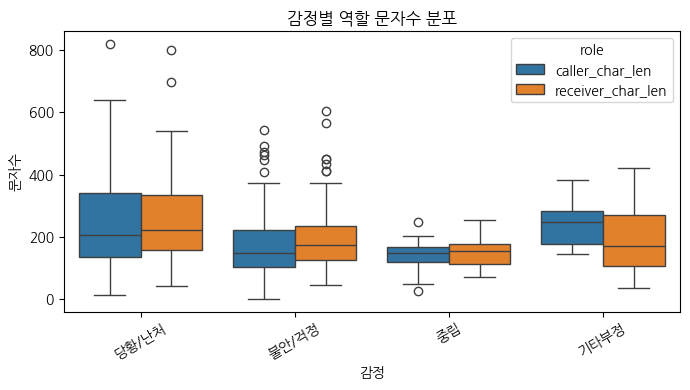

In [ ]:
# 감정별 신고자/수보자 문자수
tmp = df.melt(id_vars=["sentiment"],
                value_vars=["caller_char_len","receiver_char_len"],
                var_name="role", value_name="char_len")
plt.figure(figsize=(7,4))
sns.boxplot(data=tmp, x="sentiment", y="char_len", hue="role",
            order=df["sentiment"].value_counts().index)
plt.title("감정별 역할 문자수 분포")
plt.xlabel("감정");
plt.ylabel("문자수")
plt.xticks(rotation=30);
plt.tight_layout();
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 감정에 따라 신고자와 수보자의 문자수 분호가 다름
- `당황/난처` 일수록 신고자 중심의 긴 대화
- 긴급도 예측 시 감정(feature)과 발화량(feature)의 결합 효과 가능성

## (utterances 기반) 수치형 변수 분석

In [ ]:
num_cols_utt = [
    "receiver_char_len", "caller_char_len", "receiver_tok_len", "caller_tok_len",
    "caller_receiver_ratio_char", "caller_receiver_ratio_tok",
    "total_duration_s"
]

# 요약 통계
display(df[num_cols_utt].describe().T)

,count,mean,std,min,25%,50%,75%,max
receiver_char_len,200.0,221.155000,126.599916,35.0,131.500000,194.500000,281.000000,800.000000
caller_char_len,200.0,211.605000,133.100291,0.0,124.750000,177.500000,261.500000,819.000000
receiver_tok_len,200.0,55.170000,32.694891,10.0,32.000000,46.500000,69.000000,207.000000
caller_tok_len,200.0,55.600000,35.845845,0.0,32.000000,47.000000,70.000000,210.000000
caller_receiver_ratio_char,200.0,1.110713,0.871169,0.0,0.638238,1.016798,1.393950,10.638889
caller_receiver_ratio_tok,200.0,1.136299,0.755648,0.0,0.672146,1.072751,1.458556,8.181818
total_duration_s,200.0,67.860500,30.113659,30.1,45.475000,59.450000,83.625000,167.100000


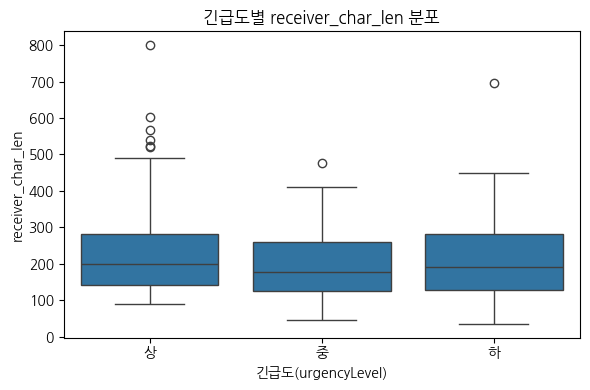

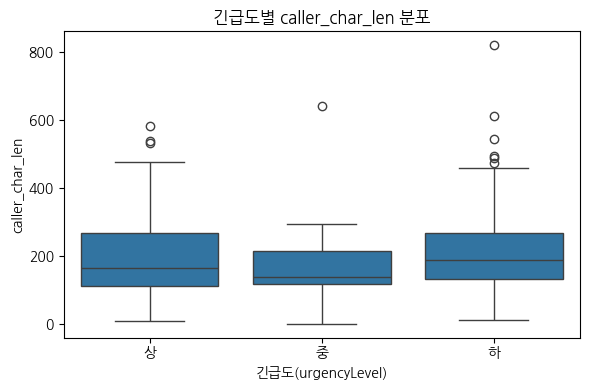

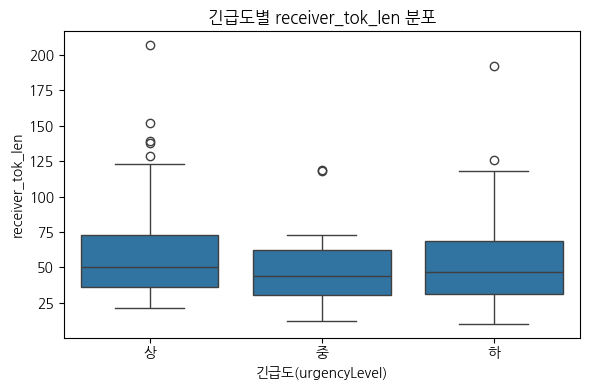

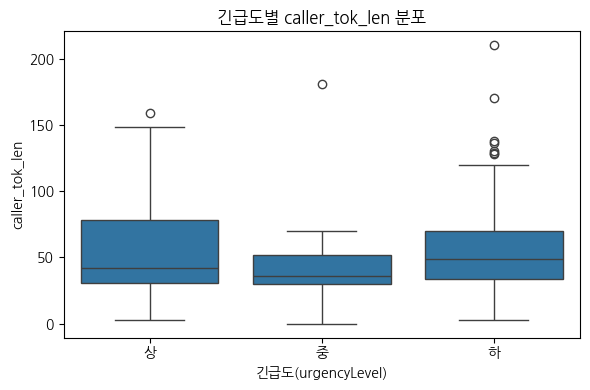

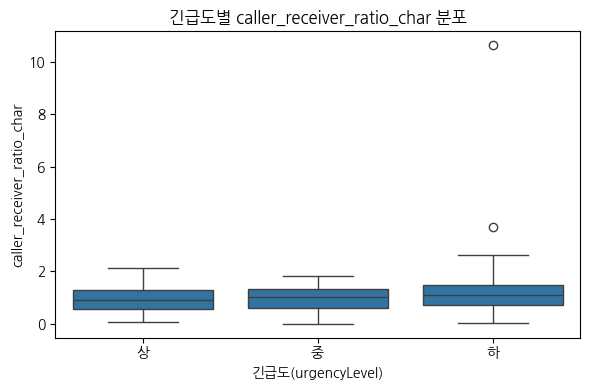

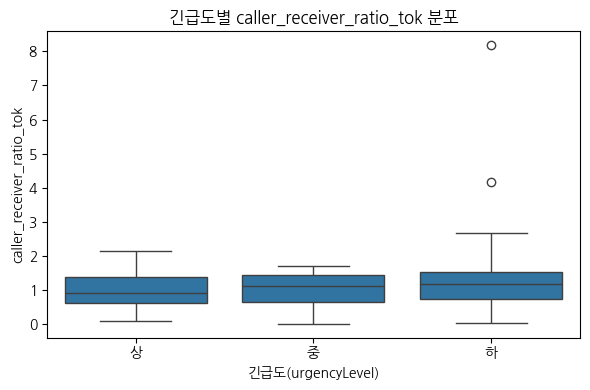

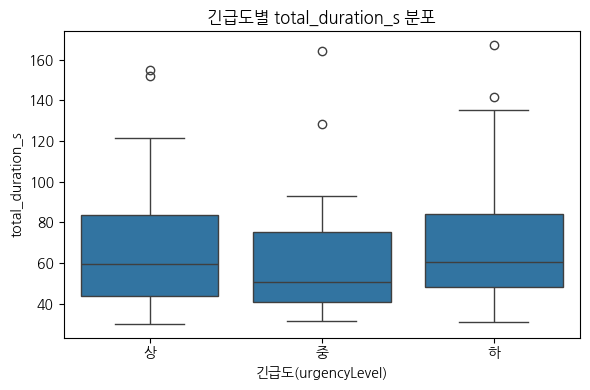

In [ ]:
# 긴급도별 boxplot
for col in num_cols_utt:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="urgencyLevel", y=col, order=order_levels)
    plt.title(f"긴급도별 {col} 분포")
    plt.xlabel("긴급도(urgencyLevel)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 긴급할수록 신고자는 말을 더 많이 길게 하고, 수보자는 일정한 수준 유지.
- 신고자 발화량과 그 변동 폭이 긴급도 판단의 핵심 신호로 작용하는 것 같음


## (utterances 기반) 범주형 변수 분석

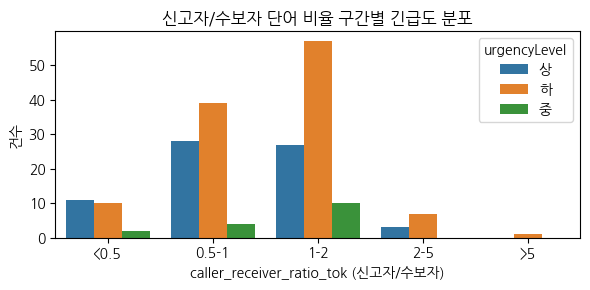

In [ ]:
# 신고자/수보자 비율(단어 기준)을 구간화
df["caller_ratio_bin"] = pd.cut(
    df["caller_receiver_ratio_tok"],
    bins=[0, 0.5, 1, 2, 5, np.inf],
    labels=["<0.5","0.5-1","1-2","2-5",">5"]
)

plt.figure(figsize=(6,3))
sns.countplot(x="caller_ratio_bin", hue="urgencyLevel", data=df,
              order=["<0.5","0.5-1","1-2","2-5",">5"])
plt.title("신고자/수보자 단어 비율 구간별 긴급도 분포")
plt.xlabel("caller_receiver_ratio_tok (신고자/수보자)")
plt.ylabel("건수")
plt.tight_layout()
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆

- 신고자/수보주 단어 비율은 긴급도의 절대적 구분 신호는 아님.
    - 대다수 신고는 1~2배 구간에서 이루어짐
- 단어 비율 단독으로는 긴급도 판별에 약해보이지만 유효한 보조 피처로 활용 가능할 듯

## (utterence 기반) 교차분석

In [ ]:
# 긴급도 vs 역할별 단어 길이 평균
if "urgencyLevel" in df.columns:
    pivot_utt_urg = df.groupby("urgencyLevel")[["receiver_tok_len", "caller_tok_len"]].mean().round(1)
    display(pivot_utt_urg)

,receiver_tok_len,caller_tok_len
urgencyLevel,,
상,60.6,55.4
중,50.5,45.8
하,52.6,57.2


⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- ‘상’일수록 양방향 대화, ‘하’일수록 일방향 대화(신고자 주도)

In [ ]:
# 감정 vs 역할별 문자/단어 비율 평균
if "sentiment" in df.columns:
    pivot_sent_utt = df.groupby("sentiment")[[
        "caller_receiver_ratio_char", "caller_receiver_ratio_tok",
        "receiver_tok_len", "caller_tok_len"
    ]].mean().round(2)
    display(pivot_sent_utt)

,caller_receiver_ratio_char,caller_receiver_ratio_tok,receiver_tok_len,caller_tok_len
sentiment,,,,
기타부정,2.59,2.25,48.29,61.14
당황/난처,1.09,1.13,64.24,66.80
불안/걱정,1.02,1.07,49.52,46.73
중립,1.06,1.05,37.14,35.62


⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 감정의 강도와 발화량은 비례하지만, 부정 감정은 긴급도와 별개인듯하다.

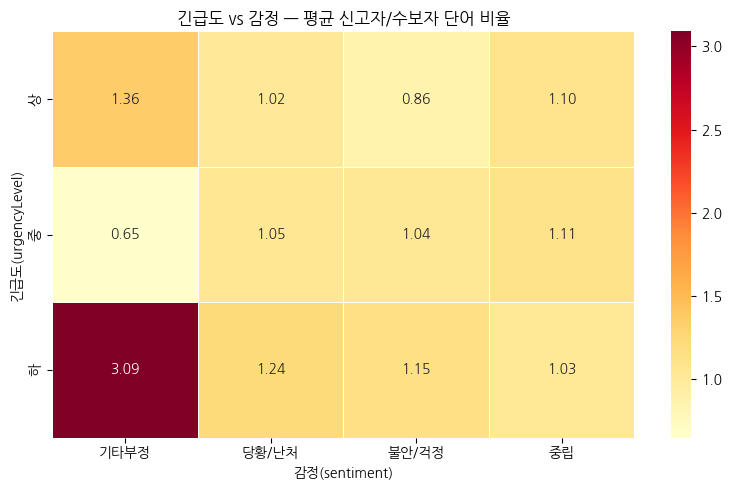

In [ ]:
# 긴급도 × 감정 — 평균 신고자/수보자 비율 히트맵
cross_utt = df.pivot_table(index="urgencyLevel", columns="sentiment",
                               values="caller_receiver_ratio_tok", aggfunc="mean")
plt.figure(figsize=(8,5))
sns.heatmap(cross_utt, annot=True, cmap="YlOrRd", fmt=".2f", linewidths=.5)
plt.title("긴급도 vs 감정 — 평균 신고자/수보자 단어 비율")
plt.xlabel("감정(sentiment)")
plt.ylabel("긴급도(urgencyLevel)")
plt.tight_layout()
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 긴급도는 단어량 자체보다 감정과 결합될 때 구분력이 커짐.
- 긴급도 `상`: 대화가 길지만 균형 잡힘 -> 실제 긴급 대응 상황
- 긴급도 `하` + 기타부정: 신고자 과다 발화 -> 민원성·비긴급성 신고 가능성

## (utterence 기반) 상관관계 분석

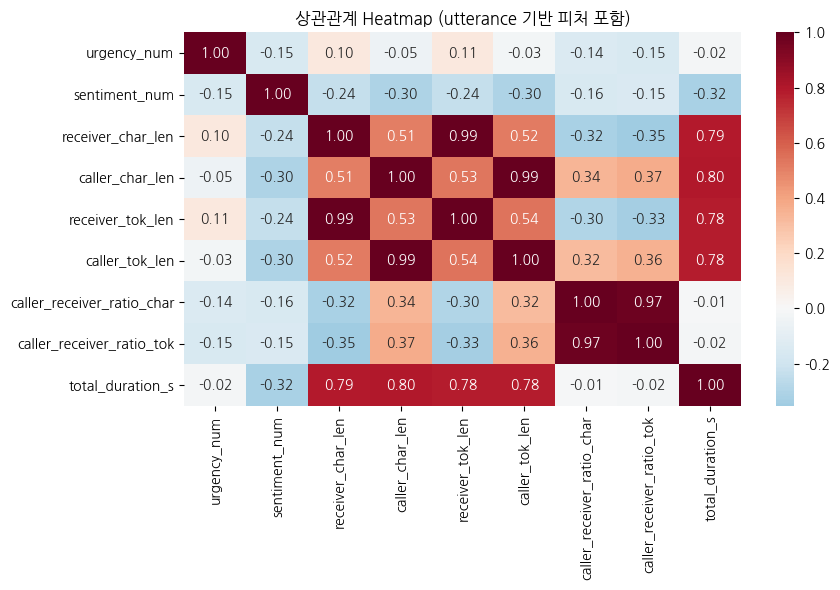

In [ ]:
# 긴급도/감정 숫자화
df["urgency_num"] = df["urgencyLevel"].map({"상":3, "중":2, "하":1}) if "urgencyLevel" in df.columns else np.nan

if "sentiment" in df.columns:
    le_sent = LabelEncoder()
    df["sentiment_num"] = le_sent.fit_transform(df["sentiment"].astype(str))
else:
    df["sentiment_num"] = np.nan

corr_cols = ["urgency_num", "sentiment_num"] + num_cols_utt
corr = df[corr_cols].corr(method="pearson")

plt.figure(figsize=(9,6))
sns.heatmap(corr, annot=True, cmap="RdBu_r", fmt=".2f", center=0)
plt.title("상관관계 Heatmap (utterance 기반 피처 포함)")
plt.tight_layout()
plt.show()

⬆⬆⬆⬆⬆⬆⬆⬆⬆⬆
- 긴급도와의 상관
    - 대부분 약함. 그나마 `receiver_char_len`, `receiver_tok_len`
    - `caller_* 길이`/`ratio_*`/`duration`은 거의 무관(−0.05 ~ 0.05 근처).
    - 단어량/비율만으로 긴급도를 설명하긴 어려움
- 감정와의 상관
    - `duration`과는 음의 상관: 감정이 강할수록 통화와 말의 길이가 짧아짐.
    - 긴급도와 감정은 약한 음의 상관: 얖선 카이제곱 결과 "유의하지만 약함"이 일관
- 단어량의 내부 상관
    - `receiver_char_len`, `receiver_tok_len` -> 0.99
    - `caller_char_len`, `caller_tok_len` -> 0.99
    - 둘다 사용하면 다중공선성 문제
- 신고자/수보자 단어/글자 수 비율
    - 서로 간 매우 큼: 둘 중 하나만 사용
    - 타깃과의 상관은 미미 -> 단독 신호로는 약함

# **결론**

### Main Feature

긴급도/감정은 내용 "무슨 말을 했는지"가 중요할 듯

### Sub Feature

- `caller_char_len` 또는 `caller_tok_len` 중 1개, `receiver_*` 중 1개, `caller_*` 중 1개
- `duration` 단독 효과는 미미, `ratio x duration`, `sentiment x duration` 는 상호작용에 의미있을 듯
- 지역/성별 편향 위험 있을 듯.

### 피처 제안(gpt 물어봄)

- 텍스트
    - TF-IDF 1–2gram(10k dims)
    - Sentence Embedding(768)
    - 키워드 flag(20~50개)
    - symptom/triage/disaster 원-핫
    - 등등..
- 대화구조: caller_tok_len, receiver_tok_len, caller_receiver_ratio_tok, turn_count, mean_tokens_per_turn,early_10s_token_share
- 오디오: log-mel(128×T) → CNN/AST 임베딩(256~768) + prosody(말속도, F0, 에너지)
- 상호작용:
    - sentiment_onehot x keyword_flags
    - ratio_tok x duration
    - early_10s_token_share x keyword_emergency

###  한줄 요약

- 상관 히트맵에서 발화량/비율/길이는 서로 강하게 중복되지만 긴급도와의 직접 상관은 약함.
- 진짜 신호는 “무슨 말을 했는지(텍스트 내용)”와 “음향/리듬(오디오)” 에
- 따라서 내용 기반 피처(키워드, TF-IDF, 임베딩) + 오디오 임베딩을 주력
- 발화량/비율/감정/기간은 보조 + 상호작용

